In [1]:
import ensembles as es
import matplotlib.pyplot as plt
import jax.numpy as jnp
import jax.random as jr
from jax.config import config
import pandas as pd 
import seaborn as sns
from glob import glob 
import numpy as np 
import optax as ox
import xarray as xr

config.update("jax_enable_x64", True)
key = jr.PRNGKey(123)
sns.set_style('whitegrid')

%load_ext autoreload
%autoreload 2

%matplotlib inline

## Data Read

### Obs

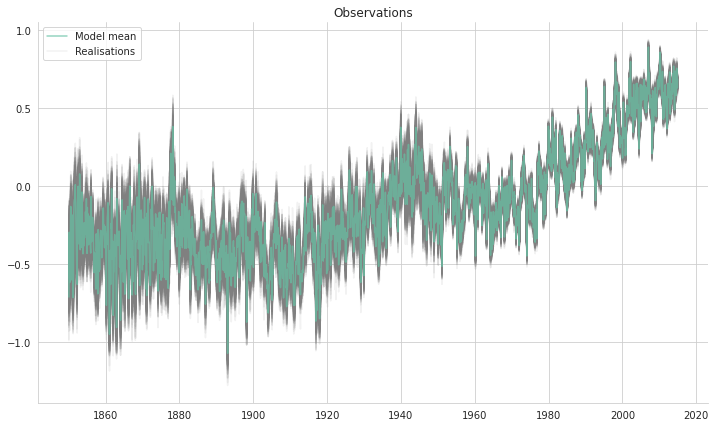

In [2]:
obs_da = xr.open_dataarray("data/obs/GMST_OBS.nc")
observations = es.ProcessModel(obs_da, model_name='Observations')
observations.plot()
sns.despine()

### Anomaly model data

In [3]:
hist_model_files = dict()
for model_file in sorted(glob('data/gmst/historical/*nc')):
    model_name = '_'.join(model_file.split("/")[-1].split('_')[1:3])
    hist_model_files[model_name] = model_file

ssp_model_files = dict()
for model_file in sorted(glob('data/gmst/ssp370/*nc')):
    model_name = '_'.join(model_file.split("/")[-1].split('_')[1:3])
    ssp_model_files[model_name] = model_file

model_overlap = np.intersect1d(list(hist_model_files.keys()), list(ssp_model_files.keys())).tolist()
hist_model_files = {k:hist_model_files[k] for k in hist_model_files if k in model_overlap}
ssp_model_files = {k:ssp_model_files[k] for k in ssp_model_files if k in model_overlap}

hist_anom_models = []
climatology_dict = dict()

for mn, mf in hist_model_files.items():
    # Read in model data into a ProcessModel datatype
    da = xr.open_dataarray(mf)
    da['time'] = observations.time
    model_data = es.ProcessModel(da, mn)

    # Find the anomally of that data
    anomaly_model = model_data.calculate_anomaly()
    hist_anom_models.append(anomaly_model)
    climatology_dict[mn] = anomaly_model.climatology

hist_anom_models = es.ModelCollection(hist_anom_models)
# hist_anom_models.plot_all()

ssp_anom_models = []
for mn, mf in ssp_model_files.items():
    # Read in model data into a ProcessModel datatype
    da = xr.open_dataarray(mf)
    model_data = es.ProcessModel(da, mn)

    # Find the anomally of that data
    anomaly_model = model_data.calculate_anomaly(climatology=climatology_dict[mn])
    ssp_anom_models.append(anomaly_model)

ssp_anom_models = es.ModelCollection(ssp_anom_models)
# ssp_anom_models.plot_all()

/home/amosm1/bayesian_ensembling/ensembles/data.py:264: UserWarning: Time axes of models don't match: applying naive fix.
  warnings.warn("Time axes of models don't match: applying naive fix.")


### Construct posteriors for historic data

In [4]:
for anom in hist_anom_models:
    model = es.MeanFieldApproximation()
    posterior = model.fit(anom, compile_objective=True)
    anom.distribution = posterior

/home/amosm1/bayesian_ensembling/ensembles/models.py:93: UserWarning: No optimiser specified, using Adam with learning rate 0.01
  warnings.warn("No optimiser specified, using Adam with learning rate 0.01")
  0%|          | 0/500 [00:00<?, ?it/s]/home/amosm1/miniconda3/envs/bayesian_ensembles/lib/python3.8/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
Objective: -11512.50: 100%|██████████| 500/500 [00:02<00:00, 231.25it/s]


### Calculate weights using different schemes

In [5]:
uniform_weights = es.UniformWeight()(hist_anom_models)
mse_weights = es.InverseSquareWeight()(hist_anom_models, observations)

weight_function = es.LogLikelihoodWeight()
ll_weights = weight_function(hist_anom_models, observations)

100%|██████████| 200/200 [00:07<00:00, 27.51it/s]


### Construct different ensemble outputs

In [6]:
weighted_mean = es.WeightedModelMean()(hist_anom_models, weights=mse_weights)
multi_model_mean = es.MultiModelMean()(hist_anom_models)
weighted_barycentre = es.Barycentre()(hist_anom_models, weights=ll_weights)

100%|██████████| 1980/1980 [00:18<00:00, 107.27it/s]


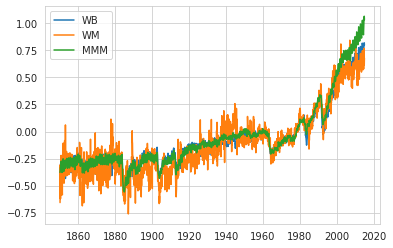

In [7]:
plt.plot(observations.time, [e.mean() for e in weighted_barycentre], label='WB')
plt.plot(observations.time, [e.mean() for e in weighted_mean], label='WM')
plt.plot(observations.time, [e.mean() for e in multi_model_mean], label='MMM')
plt.legend()
plt.show()

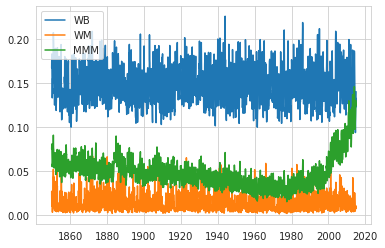

In [8]:
plt.plot(observations.time, [e.variance() for e in weighted_barycentre], label='WB')
plt.plot(observations.time, [e.variance() for e in weighted_mean], label='WM')
plt.plot(observations.time, [e.variance() for e in multi_model_mean], label='MMM')
plt.legend()
plt.show()

### Forecasts

In [9]:
for anom in ssp_anom_models:
    model = es.MeanFieldApproximation()
    posterior = model.fit(anom, compile_objective=True)
    anom.distribution = posterior

/home/amosm1/bayesian_ensembling/ensembles/models.py:93: UserWarning: No optimiser specified, using Adam with learning rate 0.01
  warnings.warn("No optimiser specified, using Adam with learning rate 0.01")
  0%|          | 0/500 [00:00<?, ?it/s]/home/amosm1/miniconda3/envs/bayesian_ensembles/lib/python3.8/site-packages/jax/_src/tree_util.py:188: FutureWarning: jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() instead as a drop-in replacement.
  warnings.warn('jax.tree_util.tree_multimap() is deprecated. Please use jax.tree_util.tree_map() '
Objective: -5735.40: 100%|██████████| 500/500 [00:02<00:00, 244.37it/s] 


Constructing weights for the forecast.

Weights could be either single, seasonal or modelled. All ensemble schemes are currently designed to take a fully dimentionalized weight as an xarray object. Would be good to wrap this up somehow into expand_weight or similar.

In [10]:
# One value weight per model
single_forecast_ll_weights = ll_weights.mean('time').expand_dims(dict(time=ssp_anom_models[0].time))

# Seasonal weights (12 values)
seasonal_forecast_ll_weights = (xr.zeros_like(es.UniformWeight()(ssp_anom_models)).groupby('time.month') + ll_weights.groupby('time.month').mean()).drop('month')

In [11]:
weighted_barycentre_single_forecast = es.Barycentre()(ssp_anom_models, weights=single_forecast_ll_weights)
weighted_barycentre_seasonal_forecast = es.Barycentre()(ssp_anom_models, weights=seasonal_forecast_ll_weights)

100%|██████████| 1032/1032 [00:09<00:00, 107.38it/s]


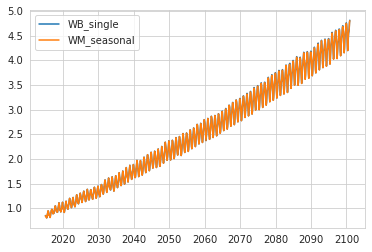

In [12]:
plt.plot(ssp_anom_models.time, [e.mean() for e in weighted_barycentre_single_forecast], label='WB_single')
plt.plot(ssp_anom_models.time, [e.mean() for e in weighted_barycentre_seasonal_forecast], label='WM_seasonal')
plt.legend()
plt.show()

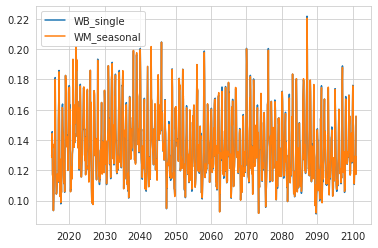

In [13]:
plt.plot(ssp_anom_models.time, [e.variance() for e in weighted_barycentre_single_forecast], label='WB_single')
plt.plot(ssp_anom_models.time, [e.variance() for e in weighted_barycentre_seasonal_forecast], label='WM_seasonal')
plt.legend()
plt.show()